<a href="https://colab.research.google.com/github/lapythie/ml/blob/master/HW03_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашка № 3.


In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import * # roc_auc_score, roc_curve
from matplotlib import pyplot

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from warnings import filterwarnings
filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, StratifiedKFold, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier

In [0]:
def metrics_func(y_true, y_predicted, average):
    acc = accuracy_score(y_true, y_predicted)
    macro_f1 = f1_score(y_true, y_predicted, average = average)
    macro_p = precision_score(y_true, y_predicted, average = average)
    macro_r = recall_score(y_true, y_predicted, average = average)
    # print('acc={0:1.4f}'.format(acc))
    print('macro F1={0:1.4f}, macro P={1:1.4f}, macro R={2:1.4f}\
    '.format(macro_f1, macro_p, macro_r))
    # return acc, macro_f1, macro_p, macro_r

def heatmap_func(y_true, y_predicted, categories):
    sns.heatmap(data=confusion_matrix(y_true, y_predicted), 
                annot=True, fmt="d", cbar=False, xticklabels=categories, 
                yticklabels=categories)
    plt.title("Confusion matrix")
    return plt.show()

Возьмите четыре любые темы из корпуса 20newsgroups

(постарайтесть брать не слишком похожие, и не слишком разные темы).

In [7]:
categories = ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']
twenty_train = fetch_20newsgroups(subset='train', categories=categories,
                                  shuffle=True, random_state=0)
twenty_test = fetch_20newsgroups(subset='test', categories=categories, 
                                 shuffle=True, random_state=0)

Векторизуйте датасет с помощью CountVectorizer.

In [0]:
def vectorize(max_doc_freq=1.0, min_doc_freq=1, 
              no_accents=None, st_words=None, ngrams=(1,1),
              x_train_data=twenty_train.data, 
              x_test_data=twenty_test.data):
    count_vect = CountVectorizer(strip_accents=no_accents, 
                                 ngram_range=ngrams, stop_words=st_words, 
                                 max_df=max_doc_freq, min_df=min_doc_freq)
    X_train_c = count_vect.fit_transform(twenty_train.data)
    print('X_train_counts.shape', X_train_c.shape)
    X_test_c = count_vect.transform(twenty_test.data)
    print('X_test.shape', X_test_c.shape)
    return X_train_c, X_test_c

In [12]:
X_train_counts, X_test = vectorize(x_train_data=twenty_train.data, 
                                   x_test_data=twenty_test.data)

X_train_counts.shape (2373, 38683)
X_test.shape (1579, 38683)


##Grid search

Выберите три любых классификатора.
Используя кроссвалидацию (любой вариант из KFold, StratifiedKFold, RepeatedStratifiedKFold), подберите оптимальные параметры моделей с помощью grid_search.

Обучите классификаторы с оптимальными параметрами.
Оцените полученные классификаторы на тесте, мера качества - macro_f1.
Посмотрите, насколько полученные результаты на тесте отличаются от результатов предсказания на трейне? - 3 балла

In [0]:
repeated_folds = fold(nfolds=3)[2]
#important

In [0]:
def gs_func(clf, parameter_grid, cv, scoring='f1_macro'):
    grid_search = GridSearchCV(clf, parameter_grid, scoring, cv=cv)
    grid_search.fit(X_train_counts, twenty_train.target)

    predicted_test = grid_search.predict(X_test)
    f1_best_estimator_test = f1_score(twenty_test.target, 
                                        predicted_test, average = 'macro')

    print('Best parameters: {}'.format(grid_search.best_params_))  
    print('Mean cross-validated score of the best_estimator: {}\
    '.format(grid_search.best_score_))
    print('Результаты на тесте. Score:\t\t\t {}\
    '.format(f1_best_estimator_test))
    
    return grid_search

def fold(nfolds=3, random_st=0, nrepeats=20, if_shuffle=True):
    folds = KFold(n_splits=nfolds, shuffle=if_shuffle, 
                  random_state=random_st)
    stratified_folds = StratifiedKFold(n_splits=nfolds, 
                                       shuffle=if_shuffle, 
                                       random_state=random_st)
    repeated_folds = RepeatedStratifiedKFold(
        n_splits=nfolds, n_repeats=nrepeats, random_state=random_st)
    return folds, stratified_folds, repeated_folds

def best_results(classifier, folds_type, 
                 params, train_counts=X_train_counts, 
                 train_target=twenty_train.target):
    lsvc_gs = gs_func(clf=classifier, parameter_grid=params, 
                      cv=folds_type, scoring='f1_macro')
    predicted_train = lsvc_gs.predict(train_counts)
    print ('\nРезультаты на трейне:')
    metrics_func(train_target, predicted_train, 'macro')

## LogisticRegression

acc=0.9025
macro F1=0.9036, macro P=0.9084,     macro R=0.9025



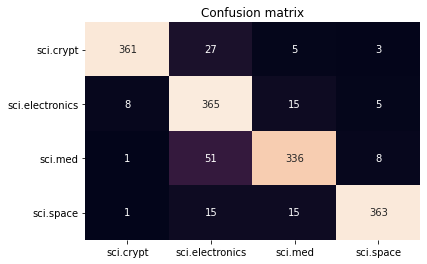

In [0]:
clf = LogisticRegression(max_iter=1000, multi_class='ovr').fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)
metrics_func(twenty_test.target, predicted, 'macro')
heatmap_func(twenty_test.target, predicted, categories)

In [0]:
%%time
parameter_grid = {
    'C' : [4.5, 5, 5.5], #or more
    'class_weight' : [None], 
    'fit_intercept' : [True], 
    # 'intercept_scaling', 
    # 'l1_ratio' : [x/10 for x in range (0,11)], #only elasticnet
    'max_iter' : [50, 300], #or less
    'penalty' : [
                 'l1', 
                 'l2', 
                 ], 
    'random_state' : [0],
    'solver' : [ 
                'liblinear'],
    'warm_start' : [False]
}
lr_gs = gs_func(LogisticRegression(), parameter_grid, cv=repeated_folds, scoring='f1_macro')

Best parameters: {'C': 5, 'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'warm_start': False}
Результаты на трейне.     Best score: 0.9474940019911847
Результаты на тесте. Score: 0.9074864666157714
CPU times: user 15min 53s, sys: 4min 1s, total: 19min 54s
Wall time: 15min 1s


In [0]:
predicted_train = lr_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

acc=1.0000
macro F1=1.0000, macro P=1.0000,     macro R=1.0000



Переобучение!

## LinearSVC

macro F1=0.9002, macro P=0.9039, macro R=0.8994    


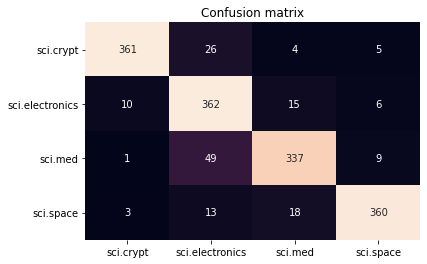

In [15]:
clf = LinearSVC().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)
metrics_func(twenty_test.target, predicted, 'macro')
heatmap_func(twenty_test.target, predicted, categories)

In [16]:
%%time
parameter_grid = {
    'C' : [0.001, 0.01, 0.08], 
    'loss' : ['hinge', 'squared_hinge'], 
    'max_iter' : [x for x in range(10,101) if x%10==0],
    'penalty' : ['l2'], 
    'random_state' : [0], 
    'verbose' : [False]
}

best_results(classifier=LinearSVC(), folds_type=repeated_folds,
             params=parameter_grid)

Best parameters: {'C': 0.01, 'loss': 'squared_hinge', 'max_iter': 30, 'penalty': 'l2', 'random_state': 0, 'verbose': False}
Mean cross-validated score of the best_estimator: 0.9484625026173632    
Результаты на тесте. Score:			\s0.9061068831213123    

Результаты на трейне:
macro F1=1.0000, macro P=1.0000, macro R=1.0000    
CPU times: user 4min 49s, sys: 2.99 s, total: 4min 52s
Wall time: 4min 53s


## MultinomialNB

macro F1=0.9353, macro P=0.9365, macro R=0.9353    


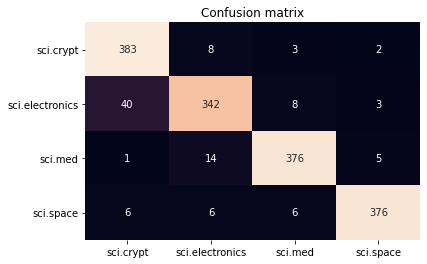

In [0]:
clf = MultinomialNB().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)
metrics_func(twenty_test.target, predicted, 'macro')
heatmap_func(twenty_test.target, predicted, categories)

In [0]:
%%time
parameter_grid = {
    'alpha' : [x/10 for x in range(0,11)], 
    'class_prior' : [None], 'fit_prior' : [True]
}

best_results(classifier=MultinomialNB(), folds_type=repeated_folds,
             params=parameter_grid)

Best parameters: {'alpha': 0.3, 'class_prior': None, 'fit_prior': True}
Mean cross-validated score of the best_estimator:	0.9749229402596413    
Результаты на тесте. Score:				0.9416926925272344    

Результаты на трейне:
macro F1=0.9992, macro P=0.9992, macro R=0.9992    
CPU times: user 9.56 s, sys: 163 ms, total: 9.73 s
Wall time: 9.74 s


## Анализируем фичи

Постройте функцию analyze_features(model, n), которая бы для каждой модели выводила самые значимые признаки по каждому из четырех классов. 
Для этого вам понадобится словарь, связывающий номер 
признака с самим признаком, он может быть таким:
index_to_word = {v:k for k,v in count_vect.vocabulary_.items()}

Обращаться к весам модели можно либо через eli5, как мы делали на лекции, либо напрямую: через clf.coef_ - матрица размера (n_classes, n_features), то есть для получения признаков с наибольшим весом для класса n вам нужно сортировать веса внутри n-ной строки.
если вы используете деревья решений, то можно воспользоваться методом  model.feature_importances - 4 балла

Примените функцию к вашим классификаторам, видны ли по отобранным словам очевидные ошибки?

In [0]:
def analyze_features(model, vectorizer, n=10, 
                     categories=categories, verbose=True):
    # вроде можно было обойтись без него, но пусть будет
    id2word = {v:k for k,v in vectorizer.vocabulary_.items()}
    weights_df = pd.DataFrame({
        categories[x]:model.coef_[x] for x in range(0,len(categories))})
    weights_df['feature'] = [id2word[x] 
                             for x in range(0,len(id2word))]
    for cat in categories:
        nfeats = weights_df.sort_values(
            by=[cat], ascending=False
            )['feature'].head(n).values
        if verbose:
            print('Category: {}.'.format(cat))
            print('{} most important features: {}.'.format(n, ', '.join(nfeats)))
        else:
            return weights_df

LogisticRegression:

In [0]:
analyze_features(model=lr_gs.best_estimator_, vectorizer=count_vect, n=10) #LogisticRegression

Category :sci.crypt.
10 most important features: clipper, encryption, key, code, security, pgp, gtoal, dos, chip, nsa.
Category :sci.electronics.
10 most important features: power, electronics, radar, circuit, motorola, tv, out, usa, line, used.
Category :sci.med.
10 most important features: doctor, msg, pitt, disease, information, medical, photography, treatment, cancer, health.
Category :sci.space.
10 most important features: space, orbit, moon, launch, planets, dc, jennise, dgi, rockets, earth.


В категории sci.electronics слово out похоже на стоп-слово, ну и used не очень информативное.

В категории sci.med видимо попалось имя - pitt.

То же самое с jennise в категории sci.space.

LinearSVC: опять out и pitt. Плюс ещё странные ee и pat.

In [0]:
analyze_features(model=lsvc_gs.best_estimator_, vectorizer=count_vect, n=10) #LinearSVC

Category :sci.crypt.
10 most important features: clipper, encryption, key, code, security, chip, pgp, gtoal, dos, nsa.
Category :sci.electronics.
10 most important features: power, electronics, circuit, radar, motorola, tv, out, line, usa, ee.
Category :sci.med.
10 most important features: doctor, msg, pitt, disease, medical, treatment, information, cancer, health, photography.
Category :sci.space.
10 most important features: space, orbit, moon, launch, dc, planets, prb, earth, solar, pat.


MultinomialNB: тут вообще жесть. Но ниже это исправляется подбором параметров векторайзера.

In [0]:
analyze_features(model=nb_gs.best_estimator_, vectorizer=count_vect, n=50) #MultinomialNB

Category :sci.crypt.
50 most important features: the, to, of, and, is, in, that, it, for, be, this, on, from, you, are, key, as, with, not, or, they, have, will, can, com, if, by, edu, encryption, what, clipper, at, but, an, chip, would, re, your, subject, one, we, lines, organization, all, has, do, about, no, government, db.
Category :sci.electronics.
50 most important features: the, to, of, and, is, in, it, for, you, that, from, edu, on, are, be, this, with, or, have, subject, lines, if, organization, com, can, at, as, but, not, re, an, one, there, what, they, use, do, would, my, any, was, about, by, some, writes, will, so, host, article, out.
Category :sci.med.
50 most important features: the, of, to, and, in, is, that, it, for, edu, this, from, you, are, be, not, with, have, or, as, com, on, but, my, was, if, can, subject, organization, lines, at, re, by, there, an, one, they, about, what, article, has, some, any, writes, your, would, do, will, no, me.
Category :sci.space.
50 most 

## Параметры CountVectorizer


Используйте параметры CountVectorizer, для того, чтобы уменьшить количество признаков и убрать нерелевантные (например числа, токены слишком низкой или высокой документной частотой, и т.д.), постарайтесь добиться улучшения результатов работы моделей (снова выводите результаты модели на трейне и на тесте, чтобы видеть, уменьшается ли переобучение) - 3 балла

1

In [0]:
count_vect = CountVectorizer(
                             strip_accents='unicode',
                             stop_words='english',
                             ngram_range=(1,2),
                             max_df=0.35,
                             min_df=0.15
                             )

X_train_counts = count_vect.fit_transform(twenty_train.data) 
#Learn the vocabulary dictionary and return term-document matrix.
print(X_train_counts.shape)
X_test = count_vect.transform(twenty_test.data)
print(X_test.shape)

(2373, 28)
(1579, 28)


In [0]:
%%time
parameter_grid = {
    'C' : [4.5, 5, 5.5], #or more
    'class_weight' : [None], 
    'fit_intercept' : [True], 
    # 'intercept_scaling', 
    # 'l1_ratio' : [x/10 for x in range (0,11)], #only elasticnet
    'max_iter' : [50, 300], #or less
    'penalty' : [
                 'l1', 
                 'l2', 
                 ], 
    'random_state' : [0], 
    'solver' : [ 
                'liblinear'],
    'warm_start' : [False]
}
lr_gs = gs_func(LogisticRegression(), parameter_grid, 
                cv=repeated_folds, scoring='f1_macro')
# accuracy и f1-macro с лучшими параметрами на трейне
predicted_train = lr_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')
# не очень хорошо

Best parameters: {'C': 5.5, 'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'warm_start': False}
Результаты на трейне.     Best score: 0.6096475505759907
Результаты на тесте. Score: 0.5281002285284604
acc=0.6228
macro F1=0.6293, macro P=0.6570,     macro R=0.6229

CPU times: user 12.9 s, sys: 16.6 ms, total: 12.9 s
Wall time: 12.9 s


In [0]:
%%time
parameter_grid = {
    'alpha' : [x/10 for x in range(0,11)], 
    'class_prior' : [None], 'fit_prior' : [True]
}
nb_gs = gs_func(MultinomialNB(), parameter_grid, 
                cv=repeated_folds, scoring='f1_macro')
# не очень хорошо

Best parameters: {'alpha': 0.0, 'class_prior': None, 'fit_prior': True}
Результаты на трейне.     Best score: 0.5809865914342013
Результаты на тесте. Score: 0.5051597808523347
CPU times: user 1.87 s, sys: 3.14 ms, total: 1.87 s
Wall time: 1.88 s


In [0]:
# accuracy и f1-macro с лучшими параметрами на трейне
predicted_train = nb_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

acc=0.5807
macro F1=0.5888, macro P=0.6428,     macro R=0.5808



2

In [18]:
count_vect = CountVectorizer(strip_accents='unicode',
                             stop_words='english',
                             ngram_range=(1,2),
                             max_df=0.5,
                             min_df=0.05
                             )

X_train_counts = count_vect.fit_transform(twenty_train.data)
print(X_train_counts.shape)

X_test = count_vect.transform(twenty_test.data)
print(X_test.shape)

(2373, 308)
(1579, 308)


In [19]:
%%time
parameter_grid = {
    'C' : [0.0001, 0.001, 0.01, 0.08, 0.1, 0.15], 
    'loss' : ['hinge', 'squared_hinge'], 
    # 'max_iter' : [x for x in range(10,101) if x%10==0],
    'max_iter' : [x for x in range(20,51) if x%10==0],
    'penalty' : ['l2'], 
    'random_state' : [0], 
    'verbose' : [False]
}
lsvc_gs = gs_func(LinearSVC(), parameter_grid, cv=repeated_folds, scoring='f1_macro')
# f1-macro с лучшими параметрами на трейне
predicted_train = lsvc_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

Best parameters: {'C': 0.01, 'loss': 'squared_hinge', 'max_iter': 30, 'penalty': 'l2', 'random_state': 0, 'verbose': False}
Mean cross-validated score of the best_estimator: 0.8339718614503339    
Результаты на тесте. Score:			\s0.7388107797030874    
macro F1=0.9070, macro P=0.9098, macro R=0.9060    
CPU times: user 45.3 s, sys: 99.9 ms, total: 45.4 s
Wall time: 45.5 s


In [0]:
%%time
parameter_grid = {
    'C' : [4.5, 5, 5.5], #or more
    'class_weight' : [None], 
    'fit_intercept' : [True], 
    # 'intercept_scaling', 
    # 'l1_ratio' : [x/10 for x in range (0,11)], #only elasticnet
    'max_iter' : [50, 300], #or less
    'penalty' : [
                 'l1', 
                 'l2', 
                 ], 
    'random_state' : [0], 
    'solver' : [ 
                'liblinear'],
    'warm_start' : [False]
}
lr_gs = gs_func(LogisticRegression(), parameter_grid, 
                cv=repeated_folds, scoring='f1_macro')
# accuracy и f1-macro с лучшими параметрами на трейне
predicted_train = lr_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

Best parameters: {'C': 4.5, 'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l2', 'random_state': 0, 'solver': 'liblinear', 'warm_start': False}
Результаты на трейне.     Best score: 0.8176514625124793
Результаты на тесте. Score: 0.7257700771689992
acc=0.9595
macro F1=0.9596, macro P=0.9598,     macro R=0.9595

CPU times: user 30min 33s, sys: 1.08 s, total: 30min 35s
Wall time: 30min 38s


In [0]:
%%time
parameter_grid = {
    'alpha' : [x/10 for x in range(0,11)], 
    'class_prior' : [None], 'fit_prior' : [False, True]
}
nb_gs = gs_func(MultinomialNB(), parameter_grid,
                cv=repeated_folds, scoring='f1_macro')

Best parameters: {'alpha': 0.0, 'class_prior': None, 'fit_prior': False}
Результаты на трейне.     Best score: 0.8213341814150952
Результаты на тесте. Score: 0.7395286837329855
CPU times: user 4.56 s, sys: 18.5 ms, total: 4.58 s
Wall time: 4.59 s


In [0]:
# accuracy и f1-macro с лучшими параметрами на трейне
predicted_train = nb_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

acc=0.8449
macro F1=0.8461, macro P=0.8537,     macro R=0.8449



3

In [21]:
count_vect = CountVectorizer(
                             strip_accents='unicode',
                             stop_words='english',
                             ngram_range=(1,2),
                             max_df=0.5,
                             min_df=0.025
                             )

X_train_counts = count_vect.fit_transform(twenty_train.data)
print(X_train_counts.shape)

X_test = count_vect.transform(twenty_test.data)
print(X_test.shape)

(2373, 877)
(1579, 877)


In [22]:
#todo
%%time
parameter_grid = {
    'C' : [0.0001, 0.001, 0.01, 0.08, 0.1, 0.15], 
    'loss' : ['hinge', 'squared_hinge'], 
    # 'max_iter' : [x for x in range(10,101) if x%10==0],
    'max_iter' : [x for x in range(20,51) if x%10==0],
    'penalty' : ['l2'], 
    'random_state' : [0], 
    'verbose' : [False]
}
lsvc_gs = gs_func(LinearSVC(), parameter_grid, cv=repeated_folds, scoring='f1_macro')
# f1-macro с лучшими параметрами на трейне
predicted_train = lsvc_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

Best parameters: {'C': 0.01, 'loss': 'squared_hinge', 'max_iter': 50, 'penalty': 'l2', 'random_state': 0, 'verbose': False}
Mean cross-validated score of the best_estimator: 0.9058171402067869    
Результаты на тесте. Score:			\s0.8499853607773504    
macro F1=0.9803, macro P=0.9808, macro R=0.9802    
CPU times: user 57.8 s, sys: 191 ms, total: 58 s
Wall time: 58 s


In [0]:
%%time
parameter_grid = {
    'C' : [4.5, 5, 5.5], #or more
    'class_weight' : [None], 
    'fit_intercept' : [True], 
    # 'intercept_scaling', 
    # 'l1_ratio' : [x/10 for x in range (0,11)], #only elasticnet
    'max_iter' : [50, 300], #or less
    'penalty' : [
                 'l1', 
                 'l2', 
                 ], 
    'random_state' : [0], 
    'solver' : [ 
                'liblinear'],
    'warm_start' : [False]
}
lr_gs = gs_func(LogisticRegression(), parameter_grid, 
                cv=repeated_folds, scoring='f1_macro')
# accuracy и f1-macro с лучшими параметрами на трейне
predicted_train = lr_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

Best parameters: {'C': 4.5, 'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'warm_start': False}
Результаты на трейне.     Best score: 0.8972538609526325
Результаты на тесте. Score: 0.8291476737534362
acc=1.0000
macro F1=1.0000, macro P=1.0000,     macro R=1.0000

CPU times: user 1h 5min 20s, sys: 1.59 s, total: 1h 5min 21s
Wall time: 1h 5min 30s


In [0]:
%%time
parameter_grid = {
    'alpha' : [x/10 for x in range(0,11)], 
    'class_prior' : [None], 'fit_prior' : [False, 
                                        #    True
                                           ]
}
nb_gs = gs_func(MultinomialNB(), parameter_grid, 
                cv=repeated_folds, scoring='f1_macro')

Best parameters: {'alpha': 0.0, 'class_prior': None, 'fit_prior': False}
Результаты на трейне.     Best score: 0.8980295878607994
Результаты на тесте. Score: 0.8323112593760045
CPU times: user 2.75 s, sys: 13.1 ms, total: 2.76 s
Wall time: 2.76 s


In [0]:
predicted_train = nb_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')
# accuracy и f1-macro с лучшими параметрами на трейне

acc=0.9182
macro F1=0.9187, macro P=0.9238,     macro R=0.9183



4

Пыталась добавить побольше стоп-слов, но вроде это не особо повлияло на качество.

In [0]:
%%capture
!pip install stop_words
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from stop_words import get_stop_words
stop_words_list = list(set(stopwords.words('english')) | set(get_stop_words('en'))) 

In [0]:
from sklearn.feature_extraction import text 
stop_words_list = text.ENGLISH_STOP_WORDS.union(stop_words_list)

In [25]:
count_vect = CountVectorizer(
                             strip_accents='unicode',
                            #  stop_words='english',
                             stop_words=stop_words_list,
                             ngram_range=(1,3),
                             max_df=0.195,
                             min_df=0.0675
                             )
categories = ['sci.crypt', 'sci.electronics', 'sci.med', 'sci.space']
X_train_counts = count_vect.fit_transform(twenty_train.data)
print(X_train_counts.shape)
X_test = count_vect.transform(twenty_test.data)
print(X_test.shape)

(2373, 149)
(1579, 149)


In [28]:
%%time
parameter_grid = {
    'C' : [0.0001, 0.001, 0.01, 0.08, 0.1, 0.15], 
    'loss' : ['hinge', 'squared_hinge'], 
    # 'max_iter' : [x for x in range(10,101) if x%10==0],
    'max_iter' : [x for x in range(20,51) if x%10==0],
    'penalty' : ['l2'], 
    'random_state' : [0], 
    'verbose' : [False]
}
lsvc_gs = gs_func(LinearSVC(), parameter_grid, cv=repeated_folds, scoring='f1_macro')
# f1-macro с лучшими параметрами на трейне
predicted_train = lsvc_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

Best parameters: {'C': 0.1, 'loss': 'squared_hinge', 'max_iter': 20, 'penalty': 'l2', 'random_state': 0, 'verbose': False}
Mean cross-validated score of the best_estimator: 0.7527976381250584    
Результаты на тесте. Score:			 0.6732926167158615    
macro F1=0.8163, macro P=0.8207, macro R=0.8145    
CPU times: user 32.1 s, sys: 38.9 ms, total: 32.2 s
Wall time: 32.2 s


In [0]:
%%time
parameter_grid = {
    'C' : [4.5, 5, 5.5], #or more
    'class_weight' : [None], 
    'fit_intercept' : [True], 
    # 'intercept_scaling', 
    # 'l1_ratio' : [x/10 for x in range (0,11)], #only elasticnet
    'max_iter' : [50, 300], #or less
    'penalty' : [
                 'l1', 
                 'l2', 
                 ], 
    'random_state' : [0], 
    'solver' : [ 
                'liblinear'],
    'warm_start' : [False]
}
lr_gs = gs_func(LogisticRegression(), parameter_grid, 
                cv=repeated_folds, scoring='f1_macro')
# accuracy и f1-macro с лучшими параметрами на трейне
predicted_train = lr_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

Best parameters: {'C': 4.5, 'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'warm_start': False}
Результаты на трейне.     Best score: 0.7472570348263929
Результаты на тесте. Score: 0.6652729999561743
acc=0.8213
macro F1=0.8228, macro P=0.8260,     macro R=0.8212

CPU times: user 5min 42s, sys: 148 ms, total: 5min 42s
Wall time: 5min 43s


In [0]:
%%time
parameter_grid = {
    'alpha' : [x/10 for x in range(0,11)], 
    'class_prior' : [None], 'fit_prior' : [False]
}
nb_gs = gs_func(MultinomialNB(), parameter_grid, 
                cv=repeated_folds, scoring='f1_macro')
# accuracy и f1-macro с лучшими параметрами на трейне
predicted_train = nb_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

Best parameters: {'alpha': 0.0, 'class_prior': None, 'fit_prior': False}
Результаты на трейне.     Best score: 0.7348168936342893
Результаты на тесте. Score: 0.6727333753390045
acc=0.7556
macro F1=0.7575, macro P=0.7645,     macro R=0.7555

CPU times: user 2.11 s, sys: 3.38 ms, total: 2.11 s
Wall time: 2.12 s


Починились важные фичи MultinomialNB:

In [0]:
analyze_features(model=nb_gs.best_estimator_, 
                 vectorizer=count_vect, n=20) #MultinomialNB

Category :sci.crypt.
20 most important features: key, encryption, clipper, chip, government, keys, public, information, clipper chip, data, used, right, bit, cs, technology, mail, computer, access, available, number.
Category :sci.electronics.
20 most important features: power, ca, need, used, work, want, current, help, line, thanks, phone, 10, using, high, way, computer, chip, make, question, number.
Category :sci.med.
20 most important features: cs, science, information, research, years, ca, 10, computer, help, world, work, 1993, david, problem, day, used, 20, way, long, case.
Category :sci.space.
20 most important features: space, nasa, gov, nasa gov, access, data, year, research, cs, program, ca, world, sci, science, work, news, 10, high, years, net.


In [29]:
%%time
parameter_grid = {
    'C' : [4.5, 5, 5.5], #or more
    'class_weight' : [None], 
    'fit_intercept' : [True], 
    # 'intercept_scaling', 
    # 'l1_ratio' : [x/10 for x in range (0,11)], #only elasticnet
    'max_iter' : [50, 300], #or less
    'penalty' : [
                 'l1', 
                 'l2', 
                 ], 
    'random_state' : [0], 
    'solver' : [ 
                'liblinear'],
    'warm_start' : [False]
}
lr_gs = gs_func(LogisticRegression(), parameter_grid, 
                cv=repeated_folds, scoring='f1_macro')
# f1-macro с лучшими параметрами на трейне
predicted_train = lr_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

Best parameters: {'C': 4.5, 'class_weight': None, 'fit_intercept': True, 'max_iter': 50, 'penalty': 'l1', 'random_state': 0, 'solver': 'liblinear', 'warm_start': False}
Mean cross-validated score of the best_estimator: 0.7472570348263929    
Результаты на тесте. Score:			 0.6652729999561743    
macro F1=0.8228, macro P=0.8260, macro R=0.8212    
CPU times: user 5min 36s, sys: 53.7 ms, total: 5min 36s
Wall time: 5min 37s


Выводы

Что помогло уменьшить переобучение:
- выкинуть низкочастотные слова,
- выкинуть высокочастотные слова,
- выкинуть стоп-слова,
- добавить нграмы.

Полностью от переобучения, однако, это не спасло.

# Trash

## SGD

In [0]:
clf = SGDClassifier().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

In [0]:
metrics_func(twenty_test.target, predicted, 'macro')

acc=0.8923
macro F1=0.8926, macro P=0.8935,     macro R=0.8923



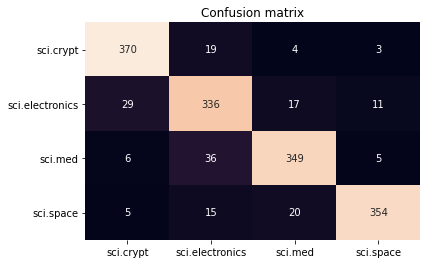

In [0]:
heatmap_func(twenty_test.target, predicted, categories)

In [0]:
%%time
parameter_grid = {
    'loss' : [
              'hinge', 'modified_huber', 
              'squared_hinge', 'perceptron',
            #   'squared_loss', 'huber', 'epsilon_insensitive', 
            #   'squared_epsilon_insensitive'
              ], 
    'max_iter' : [x for x in range(10,101) if x%10==0],
    'alpha' : [x/10 for x in range(0,11) if x > 0], 
    'penalty' : ['l2'], 
    'random_state' : [0], 
    'verbose' : [False],
    'n_jobs' : [-1],
    'learning_rate' : ['optimal'],
    'early_stopping' : [True]
}
sgd_gs = gs_func(SGDClassifier(), parameter_grid, 
                 cv=repeated_folds, 
                #  cv=folds, 
                 scoring='f1_macro')

Best parameters: {'alpha': 0.3, 'early_stopping': True, 'learning_rate': 'optimal', 'loss': 'modified_huber', 'max_iter': 20, 'n_jobs': -1, 'penalty': 'l2', 'random_state': 0, 'verbose': False}
Результаты на трейне.     Best score: 0.9341196789884832
Результаты на тесте. Score: 0.8885144165526528
CPU times: user 43min 35s, sys: 39min 23s, total: 1h 22min 58s
Wall time: 47min 36s


In [0]:
predicted_train = sgd_gs.predict(X_train_counts)
metrics_func(twenty_train.target, predicted_train, 'macro')

acc=0.9907
macro F1=0.9907, macro P=0.9908,     macro R=0.9907



In [0]:
analyze_features(model=sgd_gs.best_estimator_, 
                 vectorizer=count_vect, n=10) #SGDClassifier

Category :sci.crypt.
10 most important features: db, key, clipper, encryption, mov, government, anonymous, bh, chip, security.
Category :sci.electronics.
10 most important features: power, electronics, circuit, use, tv, company, amp, audio, hp, radar.
Category :sci.med.
10 most important features: msg, medical, health, disease, keyboard, pitt, doctor, hiv, treatment, my.
Category :sci.space.
10 most important features: space, launch, orbit, moon, earth, satellite, nasa, dc, flight, lunar.


In [0]:
# clf.predict(count_vect.transform(['']))
# clf.classes_

##Decision tree

In [0]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

In [0]:
metrics_func(twenty_test.target, predicted, 'macro')

acc=0.7473
macro F1=0.7498, macro P=0.7599, macro R=0.7474



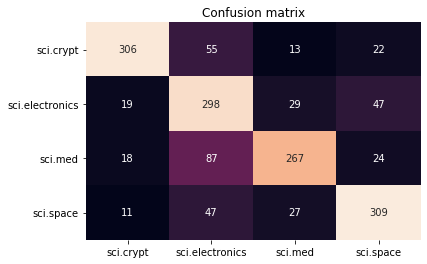

In [0]:
heatmap_func(twenty_test.target, predicted, categories)

## Random Forest

In [0]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier().fit(X_train_counts, twenty_train.target)
predicted = clf.predict(X_test)

In [0]:
metrics_func(twenty_test.target, predicted, 'macro')

acc=0.8486
macro F1=0.8522, macro P=0.8754, macro R=0.8488



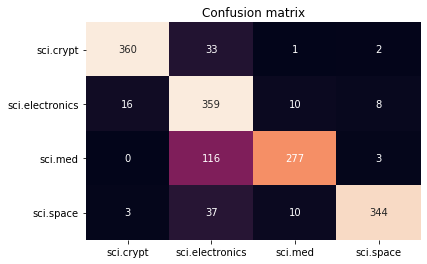

In [0]:
heatmap_func(twenty_test.target, predicted, categories)

In [0]:
# for line in twenty_train.DESCR.split('\n'):
#     print (line)